In [46]:
# Importing all necessary python libraries 
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy
import pickle
import os

from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import make_scorer, accuracy_score
# ----------------------------------------

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dense, Activation, Flatten

from bayes_opt import BayesianOptimization

from tensorflow.keras.layers import Dropout

import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
# ----------------------------------------

In [47]:
# Importing all necessary python libraries 
import pandas as pd
import networkx as nx
import numpy as np
import scipy
from scipy.sparse import csr_matrix
import pickle
import os

from model import predict_pval
from metrics import regression_metrics
# ----------------------------------------


# ----------------------------------------
data_name = 'Alzheimer'                              # 'Alzheimer' 
# prediction_type = 'regression'                      # 'classification' or 'regression' 
model_name = 'RandomForest_randomized'               # 'RandomForest_randomized' or 'RandomForest_grid' or 'NeuralNet' or 'NeuralNet_hyper'
predicting_attribute = 'pval'                        # 'chromosome' or 'jaccard_similarity' or 'pval'
rand_state_for_split = 42
embedding = 'Node2Vec'                               # 'Node2Vec' or 'Attri2Vec' or 'GraphSAGE' or 'GCN'
# ----------------------------------------

# ----------------------------------------
def construct(embedding, data_name):

    emb_file = 'pickles/generated_embeddings/{}_{}.pickle'.format(embedding, data_name)
    pval_file = '../graph-data/Alzheimers_Disease_Graph/Processed/{}_pval_hop_0.pickle'.format(data_name)
    with open(emb_file, 'rb') as handle: featureMatrix = pickle.load(handle)
    with open(pval_file, 'rb') as handle: pvalueMatrix = pickle.load(handle)
    # pvalueMatrix = pvalueMatrix.todense()
    featureMatrix = featureMatrix.to_numpy()
#     print(featureMatrix)
    print('pvalueMatrix', pvalueMatrix.shape)
#     print(pvalueMatrix)

    return featureMatrix, pvalueMatrix

In [48]:
fm, pm = construct(embedding, data_name)
print(fm.shape, pm.shape)

rand_state = 42

X_train, X_test, y_train, y_test = train_test_split(fm, pm, random_state=rand_state, test_size=0.30, shuffle=True)

pvalueMatrix (766,)
(766, 128) (766,)


In [49]:
def create_model(optimizer, activation):
    neurons = 16 

    NN_model = Sequential()
    NN_model.add(Dropout(0.2, input_dim = X_train.shape[1]))
    NN_model.add(Dense(neurons, kernel_initializer='normal', activation=activation))
    NN_model.add(Dense(neurons, kernel_initializer='normal', activation=activation))
    NN_model.add(Dense(neurons, kernel_initializer='normal', activation=activation))
    NN_model.add(Dense(neurons, kernel_initializer='normal', activation=activation))
    NN_model.add(Dense(128, kernel_initializer='normal', activation=activation))
    NN_model.add(Dense(128, kernel_initializer='normal', activation=activation))
    NN_model.add(Dense(neurons, kernel_initializer='normal', activation=activation))
    NN_model.add(Dense(neurons, kernel_initializer='normal', activation=activation))
    NN_model.add(Dense(neurons, kernel_initializer='normal', activation=activation))
    NN_model.add(Dense(neurons, kernel_initializer='normal', activation=activation))
    NN_model.add(Dropout(0.1))
    NN_model.add(Dense(1, kernel_initializer='normal', activation='linear'))

    NN_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error']) 
    return NN_model

In [50]:
# optimizers = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']
# activations = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu', 'elu', 'exponential', 'LeakyReLU']
# init_modes = ['glorot_uniform', 'uniform', 'normal'] 

param_grid = dict(epochs = [10, 20], 
                  batch_size = [32, 64, 128, 512], 
                  optimizer = ['SGD', 'Adam', 'RMSprop'], 
                  activation= ['relu', 'sigmoid', 'tanh'])

In [51]:
kr = KerasRegressor(build_fn=create_model, verbose=1)
grid = GridSearchCV(estimator=kr, param_grid=param_grid, cv=3)

In [52]:
grid_result = grid.fit(X_train, y_train)

Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 8.2706e-12 - mean_squared_error: 8.2706e-12
Epoch 2/10
12/12 [==============================] - 0s 1ms/step - loss: 7.4998e-12 - mean_squared_error: 7.4998e-12
Epoch 3/10
12/12 [==============================] - 0s 1ms/step - loss: 7.0327e-12 - mean_squared_error: 7.0327e-12
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 6.7667e-12 - mean_squared_error: 6.7667e-12
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 6.5449e-12 - mean_squared_error: 6.5449e-12
Epoch 6/10
12/12 [==============================] - 0s 1ms/step - loss: 6.4430e-12 - mean_squared_error: 6.4430e-12
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 6.3549e-12 - mean_squared_error: 6.3549e-12
Epoch 8/10
12/12 [==============================] - 0s 1ms/step - loss: 6.3231e-12 - mean_squared_error: 6.3231e-12
Epoch 9/10
12/12 [==============================] - 0s 1ms/step - loss: 

12/12 [==============================] - 0s 1ms/step - loss: 2.2578e-07 - mean_squared_error: 2.2578e-07
Epoch 7/10
12/12 [==============================] - 0s 1ms/step - loss: 2.1989e-07 - mean_squared_error: 2.1989e-07
Epoch 8/10
12/12 [==============================] - 0s 1ms/step - loss: 2.2251e-07 - mean_squared_error: 2.2251e-07
Epoch 9/10
12/12 [==============================] - 0s 1ms/step - loss: 2.2478e-07 - mean_squared_error: 2.2478e-07
Epoch 10/10
6/6 [==============================] - 0s 1ms/step - loss: 2.2749e-07 - mean_squared_error: 2.2749e-07
Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 4.7176e-07 - mean_squared_error: 4.7176e-07
Epoch 2/10
12/12 [==============================] - 0s 1ms/step - loss: 6.3524e-08 - mean_squared_error: 6.3524e-08
Epoch 3/10
12/12 [==============================] - 0s 1ms/step - loss: 2.2571e-07 - mean_squared_error: 2.2571e-07
Epoch 4/10
12/12 [==============================] - 0s 1ms/step - loss: 2.6854e-07 -

12/12 [==============================] - 0s 2ms/step - loss: 7.8668e-12 - mean_squared_error: 7.8668e-12
Epoch 3/20
12/12 [==============================] - 0s 2ms/step - loss: 7.3716e-12 - mean_squared_error: 7.3716e-12
Epoch 4/20
12/12 [==============================] - 0s 1ms/step - loss: 7.0659e-12 - mean_squared_error: 7.0659e-12
Epoch 5/20
12/12 [==============================] - 0s 1ms/step - loss: 6.8958e-12 - mean_squared_error: 6.8958e-12
Epoch 6/20
12/12 [==============================] - 0s 1ms/step - loss: 6.7826e-12 - mean_squared_error: 6.7826e-12
Epoch 7/20
12/12 [==============================] - 0s 2ms/step - loss: 6.7359e-12 - mean_squared_error: 6.7359e-12
Epoch 8/20
12/12 [==============================] - 0s 2ms/step - loss: 6.7039e-12 - mean_squared_error: 6.7039e-12
Epoch 9/20
12/12 [==============================] - 0s 1ms/step - loss: 6.6845e-12 - mean_squared_error: 6.6845e-12
Epoch 10/20
12/12 [==============================] - 0s 1ms/step - loss: 6.6721e-12

12/12 [==============================] - 0s 1ms/step - loss: 9.0074e-12 - mean_squared_error: 9.0074e-12
Epoch 10/20
12/12 [==============================] - 0s 2ms/step - loss: 1.0341e-11 - mean_squared_error: 1.0341e-11
Epoch 11/20
12/12 [==============================] - 0s 1ms/step - loss: 1.5440e-11 - mean_squared_error: 1.5440e-11
Epoch 12/20
12/12 [==============================] - 0s 1ms/step - loss: 1.2745e-11 - mean_squared_error: 1.2745e-11
Epoch 13/20
12/12 [==============================] - 0s 1ms/step - loss: 1.3439e-11 - mean_squared_error: 1.3439e-11
Epoch 14/20
12/12 [==============================] - 0s 1ms/step - loss: 9.8666e-12 - mean_squared_error: 9.8666e-12
Epoch 15/20
12/12 [==============================] - 0s 1ms/step - loss: 7.1730e-12 - mean_squared_error: 7.1730e-12
Epoch 16/20
12/12 [==============================] - 0s 1ms/step - loss: 7.2724e-12 - mean_squared_error: 7.2724e-12
Epoch 17/20
12/12 [==============================] - 0s 1ms/step - loss: 8.9

12/12 [==============================] - 0s 1ms/step - loss: 2.2570e-07 - mean_squared_error: 2.2570e-07
Epoch 17/20
12/12 [==============================] - 0s 1ms/step - loss: 2.2557e-07 - mean_squared_error: 2.2557e-07
Epoch 18/20
12/12 [==============================] - 0s 1ms/step - loss: 2.2449e-07 - mean_squared_error: 2.2449e-07
Epoch 19/20
12/12 [==============================] - 0s 1ms/step - loss: 2.2422e-07 - mean_squared_error: 2.2422e-07
Epoch 20/20
6/6 [==============================] - 0s 1ms/step - loss: 2.2186e-07 - mean_squared_error: 2.2186e-07
Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 8.4920e-12 - mean_squared_error: 8.4920e-12
Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 8.0026e-12 - mean_squared_error: 8.0026e-12
Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 7.6205e-12 - mean_squared_error: 7.6205e-12
Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 7.3255e-12 - mean

6/6 [==============================] - 1s 2ms/step - loss: 5.3337e-07 - mean_squared_error: 5.3337e-07
Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 1.8122e-07 - mean_squared_error: 1.8122e-07
Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 1.8760e-09 - mean_squared_error: 1.8760e-09
Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 1.6126e-07 - mean_squared_error: 1.6126e-07
Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 4.1259e-07 - mean_squared_error: 4.1259e-07
Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 6.4603e-08 - mean_squared_error: 6.4603e-08
Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 3.5767e-07 - mean_squared_error: 3.5767e-07
Epoch 8/10
6/6 [==============================] - 0s 2ms/step - loss: 1.6590e-07 - mean_squared_error: 1.6590e-07
Epoch 9/10
6/6 [==============================] - 0s 2ms/step - loss: 2.1473e-07 - mean_squared_err

6/6 [==============================] - 0s 2ms/step - loss: 5.8713e-12 - mean_squared_error: 5.8713e-12
Epoch 20/20
3/3 [==============================] - 0s 2ms/step - loss: 7.1569e-12 - mean_squared_error: 7.1569e-12
Epoch 1/20
6/6 [==============================] - 1s 2ms/step - loss: 8.8047e-12 - mean_squared_error: 8.8047e-12
Epoch 2/20
6/6 [==============================] - 0s 4ms/step - loss: 8.3499e-12 - mean_squared_error: 8.3499e-12
Epoch 3/20
6/6 [==============================] - 0s 2ms/step - loss: 7.9718e-12 - mean_squared_error: 7.9718e-12
Epoch 4/20
6/6 [==============================] - 0s 2ms/step - loss: 7.6825e-12 - mean_squared_error: 7.6825e-12
Epoch 5/20
6/6 [==============================] - 0s 2ms/step - loss: 7.4540e-12 - mean_squared_error: 7.4540e-12
Epoch 6/20
6/6 [==============================] - 0s 2ms/step - loss: 7.2849e-12 - mean_squared_error: 7.2849e-12
Epoch 7/20
6/6 [==============================] - 0s 2ms/step - loss: 7.1450e-12 - mean_squared_er

6/6 [==============================] - 0s 2ms/step - loss: 1.6489e-09 - mean_squared_error: 1.6489e-09
Epoch 8/20
6/6 [==============================] - 0s 2ms/step - loss: 1.3963e-09 - mean_squared_error: 1.3963e-09
Epoch 9/20
6/6 [==============================] - 0s 2ms/step - loss: 5.5300e-10 - mean_squared_error: 5.5300e-10
Epoch 10/20
6/6 [==============================] - 0s 2ms/step - loss: 3.3102e-10 - mean_squared_error: 3.3102e-10
Epoch 11/20
6/6 [==============================] - 0s 2ms/step - loss: 2.4131e-10 - mean_squared_error: 2.4131e-10
Epoch 12/20
6/6 [==============================] - 0s 2ms/step - loss: 1.2157e-10 - mean_squared_error: 1.2157e-10
Epoch 13/20
6/6 [==============================] - 0s 2ms/step - loss: 6.5083e-11 - mean_squared_error: 6.5083e-11
Epoch 14/20
6/6 [==============================] - 0s 2ms/step - loss: 3.7318e-11 - mean_squared_error: 3.7318e-11
Epoch 15/20
6/6 [==============================] - 0s 2ms/step - loss: 2.9224e-11 - mean_squar

6/6 [==============================] - 0s 2ms/step - loss: 2.2554e-07 - mean_squared_error: 2.2554e-07
Epoch 16/20
6/6 [==============================] - 0s 2ms/step - loss: 2.1924e-07 - mean_squared_error: 2.1924e-07
Epoch 17/20
6/6 [==============================] - 0s 2ms/step - loss: 2.3112e-07 - mean_squared_error: 2.3112e-07
Epoch 18/20
6/6 [==============================] - 0s 2ms/step - loss: 2.2094e-07 - mean_squared_error: 2.2094e-07
Epoch 19/20
6/6 [==============================] - 0s 2ms/step - loss: 2.2666e-07 - mean_squared_error: 2.2666e-07
Epoch 20/20
3/3 [==============================] - 0s 2ms/step - loss: 2.2332e-07 - mean_squared_error: 2.2332e-07
Epoch 1/10
3/3 [==============================] - 1s 2ms/step - loss: 8.6226e-12 - mean_squared_error: 8.6226e-12
Epoch 2/10
3/3 [==============================] - 0s 3ms/step - loss: 8.3520e-12 - mean_squared_error: 8.3520e-12
Epoch 3/10
3/3 [==============================] - 0s 2ms/step - loss: 8.1132e-12 - mean_square

2/2 [==============================] - 0s 3ms/step - loss: 4.0104e-09 - mean_squared_error: 4.0104e-09
Epoch 1/10
3/3 [==============================] - 1s 3ms/step - loss: 7.4825e-10 - mean_squared_error: 7.4825e-10
Epoch 2/10
3/3 [==============================] - 0s 3ms/step - loss: 1.3284e-06 - mean_squared_error: 1.3284e-06
Epoch 3/10
3/3 [==============================] - 0s 3ms/step - loss: 3.2406e-07 - mean_squared_error: 3.2406e-07
Epoch 4/10
3/3 [==============================] - 0s 3ms/step - loss: 7.5202e-09 - mean_squared_error: 7.5202e-09
Epoch 5/10
3/3 [==============================] - 0s 3ms/step - loss: 1.8350e-09 - mean_squared_error: 1.8350e-09
Epoch 6/10
3/3 [==============================] - 0s 3ms/step - loss: 3.2014e-09 - mean_squared_error: 3.2014e-09
Epoch 7/10
3/3 [==============================] - 0s 3ms/step - loss: 2.7417e-08 - mean_squared_error: 2.7417e-08
Epoch 8/10
3/3 [==============================] - 0s 3ms/step - loss: 4.2688e-07 - mean_squared_err

3/3 [==============================] - 0s 3ms/step - loss: 6.0962e-12 - mean_squared_error: 6.0962e-12
Epoch 19/20
3/3 [==============================] - 0s 3ms/step - loss: 6.0669e-12 - mean_squared_error: 6.0669e-12
Epoch 20/20
2/2 [==============================] - 0s 3ms/step - loss: 7.4364e-12 - mean_squared_error: 7.4364e-12
Epoch 1/20
3/3 [==============================] - 1s 3ms/step - loss: 8.8914e-12 - mean_squared_error: 8.8914e-12
Epoch 2/20
3/3 [==============================] - 0s 3ms/step - loss: 8.6284e-12 - mean_squared_error: 8.6284e-12
Epoch 3/20
3/3 [==============================] - 0s 4ms/step - loss: 8.4026e-12 - mean_squared_error: 8.4026e-12
Epoch 4/20
3/3 [==============================] - 0s 3ms/step - loss: 8.2008e-12 - mean_squared_error: 8.2008e-12
Epoch 5/20
3/3 [==============================] - 0s 3ms/step - loss: 8.0200e-12 - mean_squared_error: 8.0200e-12
Epoch 6/20
3/3 [==============================] - 0s 3ms/step - loss: 7.8546e-12 - mean_squared_e

3/3 [==============================] - 0s 3ms/step - loss: 2.7588e-08 - mean_squared_error: 2.7588e-08
Epoch 7/20
3/3 [==============================] - 0s 3ms/step - loss: 2.1736e-08 - mean_squared_error: 2.1736e-08
Epoch 8/20
3/3 [==============================] - 0s 3ms/step - loss: 6.9414e-09 - mean_squared_error: 6.9414e-09
Epoch 9/20
3/3 [==============================] - 0s 3ms/step - loss: 9.6402e-09 - mean_squared_error: 9.6402e-09
Epoch 10/20
3/3 [==============================] - 0s 3ms/step - loss: 9.5640e-09 - mean_squared_error: 9.5640e-09
Epoch 11/20
3/3 [==============================] - 0s 3ms/step - loss: 3.7173e-09 - mean_squared_error: 3.7173e-09
Epoch 12/20
3/3 [==============================] - 0s 3ms/step - loss: 2.7712e-09 - mean_squared_error: 2.7712e-09
Epoch 13/20
3/3 [==============================] - 0s 3ms/step - loss: 3.7019e-09 - mean_squared_error: 3.7019e-09
Epoch 14/20
3/3 [==============================] - 0s 3ms/step - loss: 2.4820e-09 - mean_square

3/3 [==============================] - 0s 3ms/step - loss: 3.9018e-07 - mean_squared_error: 3.9018e-07
Epoch 15/20
3/3 [==============================] - 0s 3ms/step - loss: 1.9351e-07 - mean_squared_error: 1.9351e-07
Epoch 16/20
3/3 [==============================] - 0s 3ms/step - loss: 1.4042e-07 - mean_squared_error: 1.4042e-07
Epoch 17/20
3/3 [==============================] - 0s 3ms/step - loss: 1.9574e-07 - mean_squared_error: 1.9574e-07
Epoch 18/20
3/3 [==============================] - 0s 3ms/step - loss: 3.0408e-07 - mean_squared_error: 3.0408e-07
Epoch 19/20
3/3 [==============================] - 0s 3ms/step - loss: 3.0185e-07 - mean_squared_error: 3.0185e-07
Epoch 20/20
2/2 [==============================] - 0s 3ms/step - loss: 1.8654e-07 - mean_squared_error: 1.8654e-07
Epoch 1/10
1/1 [==============================] - 1s 817ms/step - loss: 8.7191e-12 - mean_squared_error: 8.7191e-12
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 8.6223e-12 - mean_squ

1/1 [==============================] - 0s 141ms/step - loss: 6.8549e-08 - mean_squared_error: 6.8549e-08
Epoch 1/10
1/1 [==============================] - 1s 861ms/step - loss: 8.7780e-12 - mean_squared_error: 8.7780e-12
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 8.0600e-11 - mean_squared_error: 8.0600e-11
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 2.1334e-09 - mean_squared_error: 2.1334e-09
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 5.9696e-08 - mean_squared_error: 5.9696e-08
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 1.2987e-06 - mean_squared_error: 1.2987e-06
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 2.9094e-06 - mean_squared_error: 2.9094e-06
Epoch 7/10
1/1 [==============================] - 0s 7ms/step - loss: 7.6066e-07 - mean_squared_error: 7.6066e-07
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 1.5723e-07 - mean_squared

1/1 [==============================] - 0s 6ms/step - loss: 6.9385e-12 - mean_squared_error: 6.9385e-12
Epoch 18/20
1/1 [==============================] - 0s 6ms/step - loss: 6.8960e-12 - mean_squared_error: 6.8960e-12
Epoch 19/20
1/1 [==============================] - 0s 5ms/step - loss: 6.8520e-12 - mean_squared_error: 6.8520e-12
Epoch 20/20
1/1 [==============================] - 0s 157ms/step - loss: 8.3892e-12 - mean_squared_error: 8.3892e-12
Epoch 1/20
1/1 [==============================] - 1s 861ms/step - loss: 8.9442e-12 - mean_squared_error: 8.9442e-12
Epoch 2/20
1/1 [==============================] - 0s 7ms/step - loss: 8.8464e-12 - mean_squared_error: 8.8464e-12
Epoch 3/20
1/1 [==============================] - 0s 6ms/step - loss: 8.7549e-12 - mean_squared_error: 8.7549e-12
Epoch 4/20
1/1 [==============================] - 0s 6ms/step - loss: 8.6740e-12 - mean_squared_error: 8.6740e-12
Epoch 5/20
1/1 [==============================] - 0s 6ms/step - loss: 8.5873e-12 - mean_squa

Epoch 5/20
1/1 [==============================] - 0s 6ms/step - loss: 3.6583e-08 - mean_squared_error: 3.6583e-08
Epoch 6/20
1/1 [==============================] - 0s 5ms/step - loss: 2.9021e-08 - mean_squared_error: 2.9021e-08
Epoch 7/20
1/1 [==============================] - 0s 6ms/step - loss: 1.1710e-07 - mean_squared_error: 1.1710e-07
Epoch 8/20
1/1 [==============================] - 0s 5ms/step - loss: 7.0904e-08 - mean_squared_error: 7.0904e-08
Epoch 9/20
1/1 [==============================] - 0s 5ms/step - loss: 2.8852e-09 - mean_squared_error: 2.8852e-09
Epoch 10/20
1/1 [==============================] - 0s 6ms/step - loss: 3.5551e-08 - mean_squared_error: 3.5551e-08
Epoch 11/20
1/1 [==============================] - 0s 5ms/step - loss: 7.8548e-08 - mean_squared_error: 7.8548e-08
Epoch 12/20
1/1 [==============================] - 0s 5ms/step - loss: 3.9224e-08 - mean_squared_error: 3.9224e-08
Epoch 13/20
1/1 [==============================] - 0s 6ms/step - loss: 2.4846e-09 - m

1/1 [==============================] - 0s 4ms/step - loss: 1.7898e-09 - mean_squared_error: 1.7898e-09
Epoch 14/20
1/1 [==============================] - 0s 5ms/step - loss: 1.4410e-09 - mean_squared_error: 1.4410e-09
Epoch 15/20
1/1 [==============================] - 0s 5ms/step - loss: 1.4096e-09 - mean_squared_error: 1.4096e-09
Epoch 16/20
1/1 [==============================] - 0s 4ms/step - loss: 1.6568e-09 - mean_squared_error: 1.6568e-09
Epoch 17/20
1/1 [==============================] - 0s 4ms/step - loss: 2.3172e-09 - mean_squared_error: 2.3172e-09
Epoch 18/20
1/1 [==============================] - 0s 4ms/step - loss: 3.8214e-09 - mean_squared_error: 3.8214e-09
Epoch 19/20
1/1 [==============================] - 0s 4ms/step - loss: 7.3627e-09 - mean_squared_error: 7.3627e-09
Epoch 20/20
1/1 [==============================] - 0s 117ms/step - loss: 4.1427e-08 - mean_squared_error: 4.1427e-08
Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.0016 - mean_squa

6/6 [==============================] - 0s 1ms/step - loss: 1.0724e-06 - mean_squared_error: 1.0724e-06
Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 2/10
12/12 [==============================] - 0s 1ms/step - loss: 0.0010 - mean_squared_error: 0.0010    
Epoch 3/10
12/12 [==============================] - 0s 1ms/step - loss: 8.2243e-04 - mean_squared_error: 8.2243e-04
Epoch 4/10
12/12 [==============================] - 0s 1ms/step - loss: 8.5051e-04 - mean_squared_error: 8.5051e-04
Epoch 5/10
12/12 [==============================] - 0s 1ms/step - loss: 6.8303e-04 - mean_squared_error: 6.8303e-04
Epoch 6/10
12/12 [==============================] - 0s 1ms/step - loss: 5.3396e-04 - mean_squared_error: 5.3396e-04
Epoch 7/10
12/12 [==============================] - 0s 1ms/step - loss: 4.3388e-04 - mean_squared_error: 4.3388e-04
Epoch 8/10
12/12 [==============================] - 0s 1ms/step - loss: 4.2550e-04 - mean_squared

12/12 [==============================] - 0s 1ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 18/20
12/12 [==============================] - 0s 1ms/step - loss: 0.0011 - mean_squared_error: 0.0011    
Epoch 19/20
12/12 [==============================] - 0s 1ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 20/20
6/6 [==============================] - 0s 1ms/step - loss: 3.5296e-07 - mean_squared_error: 3.5296e-07
Epoch 1/20
12/12 [==============================] - 1s 2ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 2/20
12/12 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 3/20
12/12 [==============================] - 0s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011    
Epoch 4/20
12/12 [==============================] - 0s 2ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 5/20
12/12 [==============================] - 0s 2ms/step - loss: 9.9931e-04 - mean_squared_error: 9.9931e-04
Epoch 6/20
12/

12/12 [==============================] - 0s 2ms/step - loss: 9.5204e-04 - mean_squared_error: 9.5204e-04
Epoch 7/20
12/12 [==============================] - 0s 2ms/step - loss: 9.3571e-04 - mean_squared_error: 9.3571e-04
Epoch 8/20
12/12 [==============================] - 0s 2ms/step - loss: 8.7204e-04 - mean_squared_error: 8.7204e-04
Epoch 9/20
12/12 [==============================] - 0s 2ms/step - loss: 7.2864e-04 - mean_squared_error: 7.2864e-04
Epoch 10/20
12/12 [==============================] - 0s 1ms/step - loss: 9.1840e-04 - mean_squared_error: 9.1840e-04
Epoch 11/20
12/12 [==============================] - 0s 1ms/step - loss: 8.2157e-04 - mean_squared_error: 8.2157e-04
Epoch 12/20
12/12 [==============================] - 0s 2ms/step - loss: 6.9336e-04 - mean_squared_error: 6.9336e-04
Epoch 13/20
12/12 [==============================] - 0s 2ms/step - loss: 7.2671e-04 - mean_squared_error: 7.2671e-04
Epoch 14/20
12/12 [==============================] - 0s 1ms/step - loss: 5.1106

12/12 [==============================] - 0s 1ms/step - loss: 1.2885e-04 - mean_squared_error: 1.2885e-04
Epoch 14/20
12/12 [==============================] - 0s 1ms/step - loss: 9.3414e-05 - mean_squared_error: 9.3414e-05
Epoch 15/20
12/12 [==============================] - 0s 1ms/step - loss: 7.9208e-05 - mean_squared_error: 7.9208e-05
Epoch 16/20
12/12 [==============================] - 0s 1ms/step - loss: 7.7726e-05 - mean_squared_error: 7.7726e-05
Epoch 17/20
12/12 [==============================] - 0s 1ms/step - loss: 5.3477e-05 - mean_squared_error: 5.3477e-05
Epoch 18/20
12/12 [==============================] - 0s 1ms/step - loss: 5.2810e-05 - mean_squared_error: 5.2810e-05
Epoch 19/20
12/12 [==============================] - 0s 1ms/step - loss: 4.8553e-05 - mean_squared_error: 4.8553e-05
Epoch 20/20
6/6 [==============================] - 0s 1ms/step - loss: 1.0760e-04 - mean_squared_error: 1.0760e-04
Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.0095 -

3/3 [==============================] - 0s 2ms/step - loss: 1.8117e-07 - mean_squared_error: 1.8117e-07
Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 7.8217e-04 - mean_squared_error: 7.8217e-04
Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 8.9547e-04 - mean_squared_error: 8.9547e-04
Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 8.3431e-04 - mean_squared_error: 8.3431e-04
Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 8.4668e-04 - mean_squared_error: 8.4668e-04
Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 7.3977e-04 - mean_squared_error: 7.3977e-04
Epoch 8/10
6/6 [==============================] - 0s 2ms/step - loss: 6.9302e-04 - mean_squared_error: 6.9302e-04
E

6/6 [==============================] - 0s 2ms/step - loss: 7.8537e-04 - mean_squared_error: 7.8537e-04
Epoch 20/20
3/3 [==============================] - 0s 2ms/step - loss: 9.9713e-07 - mean_squared_error: 9.9713e-07
Epoch 1/20
6/6 [==============================] - 1s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 2/20
6/6 [==============================] - 0s 2ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 3/20
6/6 [==============================] - 0s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 4/20
6/6 [==============================] - 0s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 5/20
6/6 [==============================] - 0s 2ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 6/20
6/6 [==============================] - 0s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011    
Epoch 7/20
6/6 [==============================] - 0s 2ms/step - loss: 9.5842e-04 - mean_squared_error: 9.5842e-04
Epoch 8/20
6/6 [============

6/6 [==============================] - 0s 2ms/step - loss: 5.6232e-04 - mean_squared_error: 5.6232e-04
Epoch 10/20
6/6 [==============================] - 0s 2ms/step - loss: 6.2316e-04 - mean_squared_error: 6.2316e-04
Epoch 11/20
6/6 [==============================] - 0s 2ms/step - loss: 5.1856e-04 - mean_squared_error: 5.1856e-04
Epoch 12/20
6/6 [==============================] - 0s 2ms/step - loss: 4.4724e-04 - mean_squared_error: 4.4724e-04
Epoch 13/20
6/6 [==============================] - 0s 3ms/step - loss: 4.3365e-04 - mean_squared_error: 4.3365e-04
Epoch 14/20
6/6 [==============================] - 0s 2ms/step - loss: 3.9870e-04 - mean_squared_error: 3.9870e-04
Epoch 15/20
6/6 [==============================] - 0s 2ms/step - loss: 3.8643e-04 - mean_squared_error: 3.8643e-04
Epoch 16/20
6/6 [==============================] - 0s 2ms/step - loss: 3.9863e-04 - mean_squared_error: 3.9863e-04
Epoch 17/20
6/6 [==============================] - 0s 2ms/step - loss: 3.4546e-04 - mean_squ

6/6 [==============================] - 0s 2ms/step - loss: 1.4941e-04 - mean_squared_error: 1.4941e-04
Epoch 20/20
3/3 [==============================] - 0s 2ms/step - loss: 4.5852e-05 - mean_squared_error: 4.5852e-05
Epoch 1/10
3/3 [==============================] - 1s 3ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2/10
3/3 [==============================] - 0s 3ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 3/10
3/3 [==============================] - 0s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 4/10
3/3 [==============================] - 0s 3ms/step - loss: 8.9738e-04 - mean_squared_error: 8.9738e-04
Epoch 5/10
3/3 [==============================] - 0s 3ms/step - loss: 7.4296e-04 - mean_squared_error: 7.4296e-04
Epoch 6/10
3/3 [==============================] - 0s 3ms/step - loss: 6.8418e-04 - mean_squared_error: 6.8418e-04
Epoch 7/10
3/3 [==============================] - 0s 3ms/step - loss: 6.9654e-04 - mean_squared_error: 6.9654e-04
Epoch 8/

3/3 [==============================] - 0s 3ms/step - loss: 3.8183e-04 - mean_squared_error: 3.8183e-04
Epoch 7/10
3/3 [==============================] - 0s 3ms/step - loss: 3.0856e-04 - mean_squared_error: 3.0856e-04
Epoch 8/10
3/3 [==============================] - 0s 3ms/step - loss: 2.8333e-04 - mean_squared_error: 2.8333e-04
Epoch 9/10
3/3 [==============================] - 0s 3ms/step - loss: 3.1849e-04 - mean_squared_error: 3.1849e-04
Epoch 10/10
2/2 [==============================] - 0s 3ms/step - loss: 5.0174e-05 - mean_squared_error: 5.0174e-05
Epoch 1/10
3/3 [==============================] - 1s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 2/10
3/3 [==============================] - 0s 3ms/step - loss: 8.8509e-04 - mean_squared_error: 8.8509e-04
Epoch 3/10
3/3 [==============================] - 0s 3ms/step - loss: 8.0505e-04 - mean_squared_error: 8.0505e-04
Epoch 4/10
3/3 [==============================] - 0s 3ms/step - loss: 7.5509e-04 - mean_squared_error: 7.5

3/3 [==============================] - 0s 3ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 7/20
3/3 [==============================] - 0s 3ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 8/20
3/3 [==============================] - 0s 3ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 9/20
3/3 [==============================] - 0s 3ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 10/20
3/3 [==============================] - 0s 3ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 11/20
3/3 [==============================] - 0s 3ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 12/20
3/3 [==============================] - 0s 3ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 13/20
3/3 [==============================] - 0s 3ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 14/20
3/3 [==============================] - 0s 3ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 15/20
3/3 [==============================] - 0

3/3 [==============================] - 0s 3ms/step - loss: 2.5598e-04 - mean_squared_error: 2.5598e-04
Epoch 18/20
3/3 [==============================] - 0s 3ms/step - loss: 2.0220e-04 - mean_squared_error: 2.0220e-04
Epoch 19/20
3/3 [==============================] - 0s 2ms/step - loss: 2.2485e-04 - mean_squared_error: 2.2485e-04
Epoch 20/20
2/2 [==============================] - 0s 3ms/step - loss: 2.2933e-08 - mean_squared_error: 2.2933e-08
Epoch 1/20
3/3 [==============================] - 1s 3ms/step - loss: 0.0312 - mean_squared_error: 0.0312
Epoch 2/20
3/3 [==============================] - 0s 3ms/step - loss: 0.0147 - mean_squared_error: 0.0147
Epoch 3/20
3/3 [==============================] - 0s 2ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 4/20
3/3 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 5/20
3/3 [==============================] - 0s 2ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 6/20
3/3 [======

1/1 [==============================] - 0s 5ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 8/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 9/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 10/10
1/1 [==============================] - 0s 119ms/step - loss: 4.5064e-04 - mean_squared_error: 4.5064e-04
Epoch 1/10
1/1 [==============================] - 1s 676ms/step - loss: 0.0501 - mean_squared_error: 0.0501
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0396 - mean_squared_error: 0.0396
Epoch 3/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 4/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0273 - mean_squared_error: 0.0273
Epoch 5/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0227 - mean_squared_error: 0.0227
Epoch 6/10
1/1 [============================

1/1 [==============================] - 0s 4ms/step - loss: 0.0364 - mean_squared_error: 0.0364
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0320 - mean_squared_error: 0.0320
Epoch 8/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0283 - mean_squared_error: 0.0283
Epoch 9/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0238 - mean_squared_error: 0.0238
Epoch 10/10
1/1 [==============================] - 0s 127ms/step - loss: 0.0164 - mean_squared_error: 0.0164
Epoch 1/10
1/1 [==============================] - 1s 835ms/step - loss: 0.0764 - mean_squared_error: 0.0764
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0584 - mean_squared_error: 0.0584
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0499 - mean_squared_error: 0.0499
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0423 - mean_squared_error: 0.0423
Epoch 5/10
1/1 [==============================] - 0s

1/1 [==============================] - 0s 5ms/step - loss: 7.5853e-04 - mean_squared_error: 7.5853e-04
Epoch 19/20
1/1 [==============================] - 0s 5ms/step - loss: 7.1522e-04 - mean_squared_error: 7.1522e-04
Epoch 20/20
1/1 [==============================] - 0s 124ms/step - loss: 1.4050e-05 - mean_squared_error: 1.4050e-05
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 2/20
1/1 [==============================] - 0s 5ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 3/20
1/1 [==============================] - 0s 5ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 4/20
1/1 [==============================] - 0s 5ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 5/20
1/1 [==============================] - 0s 5ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 6/20
1/1 [==============================] - 0s 5ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 7/20
1/1 [==============

1/1 [==============================] - 0s 4ms/step - loss: 7.0668e-04 - mean_squared_error: 7.0668e-04
Epoch 10/20
1/1 [==============================] - 0s 4ms/step - loss: 7.3159e-04 - mean_squared_error: 7.3159e-04
Epoch 11/20
1/1 [==============================] - 0s 4ms/step - loss: 6.9509e-04 - mean_squared_error: 6.9509e-04
Epoch 12/20
1/1 [==============================] - 0s 4ms/step - loss: 7.4908e-04 - mean_squared_error: 7.4908e-04
Epoch 13/20
1/1 [==============================] - 0s 4ms/step - loss: 5.3949e-04 - mean_squared_error: 5.3949e-04
Epoch 14/20
1/1 [==============================] - 0s 4ms/step - loss: 7.0170e-04 - mean_squared_error: 7.0170e-04
Epoch 15/20
1/1 [==============================] - 0s 4ms/step - loss: 5.2939e-04 - mean_squared_error: 5.2939e-04
Epoch 16/20
1/1 [==============================] - 0s 4ms/step - loss: 6.8093e-04 - mean_squared_error: 6.8093e-04
Epoch 17/20
1/1 [==============================] - 0s 4ms/step - loss: 6.4791e-04 - mean_squ

12/12 [==============================] - 0s 1ms/step - loss: 5.8976e-12 - mean_squared_error: 5.8976e-12
Epoch 9/10
12/12 [==============================] - 0s 1ms/step - loss: 5.8636e-12 - mean_squared_error: 5.8636e-12
Epoch 10/10
6/6 [==============================] - 0s 1ms/step - loss: 7.2751e-12 - mean_squared_error: 7.2751e-12
Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 8.5450e-12 - mean_squared_error: 8.5450e-12
Epoch 2/10
12/12 [==============================] - 0s 1ms/step - loss: 7.6885e-12 - mean_squared_error: 7.6885e-12
Epoch 3/10
12/12 [==============================] - 0s 1ms/step - loss: 7.3420e-12 - mean_squared_error: 7.3420e-12
Epoch 4/10
12/12 [==============================] - 0s 1ms/step - loss: 7.0289e-12 - mean_squared_error: 7.0289e-12
Epoch 5/10
12/12 [==============================] - 0s 1ms/step - loss: 6.8752e-12 - mean_squared_error: 6.8752e-12
Epoch 6/10
12/12 [==============================] - 0s 1ms/step - loss: 6.7498e-12 -

12/12 [==============================] - 0s 1ms/step - loss: 8.4933e-08 - mean_squared_error: 8.4933e-08
Epoch 3/10
12/12 [==============================] - 0s 1ms/step - loss: 3.0643e-07 - mean_squared_error: 3.0643e-07
Epoch 4/10
12/12 [==============================] - 0s 1ms/step - loss: 3.5505e-07 - mean_squared_error: 3.5505e-07
Epoch 5/10
12/12 [==============================] - 0s 1ms/step - loss: 3.0335e-07 - mean_squared_error: 3.0335e-07
Epoch 6/10
12/12 [==============================] - 0s 1ms/step - loss: 2.8117e-07 - mean_squared_error: 2.8117e-07
Epoch 7/10
12/12 [==============================] - 0s 1ms/step - loss: 2.8174e-07 - mean_squared_error: 2.8174e-07
Epoch 8/10
12/12 [==============================] - 0s 1ms/step - loss: 2.9257e-07 - mean_squared_error: 2.9257e-07
Epoch 9/10
12/12 [==============================] - 0s 1ms/step - loss: 2.9198e-07 - mean_squared_error: 2.9198e-07
Epoch 10/10
6/6 [==============================] - 0s 1ms/step - loss: 2.8066e-07 -

12/12 [==============================] - 0s 1ms/step - loss: 6.6554e-12 - mean_squared_error: 6.6554e-12
Epoch 20/20
6/6 [==============================] - 0s 1ms/step - loss: 5.5327e-12 - mean_squared_error: 5.5327e-12
Epoch 1/20
12/12 [==============================] - 1s 2ms/step - loss: 1.6087e-07 - mean_squared_error: 1.6087e-07
Epoch 2/20
12/12 [==============================] - 0s 2ms/step - loss: 4.3565e-08 - mean_squared_error: 4.3565e-08
Epoch 3/20
12/12 [==============================] - 0s 1ms/step - loss: 1.3089e-08 - mean_squared_error: 1.3089e-08
Epoch 4/20
12/12 [==============================] - 0s 1ms/step - loss: 3.6378e-09 - mean_squared_error: 3.6378e-09
Epoch 5/20
12/12 [==============================] - 0s 1ms/step - loss: 9.3986e-10 - mean_squared_error: 9.3986e-10
Epoch 6/20
12/12 [==============================] - 0s 1ms/step - loss: 3.8656e-10 - mean_squared_error: 3.8656e-10
Epoch 7/20
12/12 [==============================] - 0s 1ms/step - loss: 1.1661e-10 -

12/12 [==============================] - 0s 1ms/step - loss: 3.4170e-07 - mean_squared_error: 3.4170e-07
Epoch 6/20
12/12 [==============================] - 0s 1ms/step - loss: 3.1387e-07 - mean_squared_error: 3.1387e-07
Epoch 7/20
12/12 [==============================] - 0s 1ms/step - loss: 3.2290e-07 - mean_squared_error: 3.2290e-07
Epoch 8/20
12/12 [==============================] - 0s 1ms/step - loss: 3.3430e-07 - mean_squared_error: 3.3430e-07
Epoch 9/20
12/12 [==============================] - 0s 1ms/step - loss: 3.4827e-07 - mean_squared_error: 3.4827e-07
Epoch 10/20
12/12 [==============================] - 0s 1ms/step - loss: 3.2374e-07 - mean_squared_error: 3.2374e-07
Epoch 11/20
12/12 [==============================] - 0s 1ms/step - loss: 3.3770e-07 - mean_squared_error: 3.3770e-07
Epoch 12/20
12/12 [==============================] - 0s 1ms/step - loss: 3.4756e-07 - mean_squared_error: 3.4756e-07
Epoch 13/20
12/12 [==============================] - 0s 1ms/step - loss: 3.4697e

6/6 [==============================] - 0s 2ms/step - loss: 7.3716e-12 - mean_squared_error: 7.3716e-12
Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 7.0299e-12 - mean_squared_error: 7.0299e-12
Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 6.7813e-12 - mean_squared_error: 6.7813e-12
Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 6.5558e-12 - mean_squared_error: 6.5558e-12
Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 6.4385e-12 - mean_squared_error: 6.4385e-12
Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 6.3088e-12 - mean_squared_error: 6.3088e-12
Epoch 8/10
6/6 [==============================] - 0s 2ms/step - loss: 6.2234e-12 - mean_squared_error: 6.2234e-12
Epoch 9/10
6/6 [==============================] - 0s 2ms/step - loss: 6.1299e-12 - mean_squared_error: 6.1299e-12
Epoch 10/10
3/3 [==============================] - 0s 2ms/step - loss: 7.4264e-12 - mean_squared_er

6/6 [==============================] - 0s 2ms/step - loss: 3.4253e-07 - mean_squared_error: 3.4253e-07
Epoch 9/10
6/6 [==============================] - 0s 2ms/step - loss: 2.6355e-07 - mean_squared_error: 2.6355e-07
Epoch 10/10
3/3 [==============================] - 0s 2ms/step - loss: 3.1833e-07 - mean_squared_error: 3.1833e-07
Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 6.1339e-07 - mean_squared_error: 6.1339e-07
Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 4.1602e-07 - mean_squared_error: 4.1602e-07
Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 5.7847e-09 - mean_squared_error: 5.7847e-09
Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 1.9733e-07 - mean_squared_error: 1.9733e-07
Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 6.1976e-07 - mean_squared_error: 6.1976e-07
Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 1.0420e-07 - mean_squared_er

6/6 [==============================] - 0s 2ms/step - loss: 6.7207e-12 - mean_squared_error: 6.7207e-12
Epoch 17/20
6/6 [==============================] - 0s 2ms/step - loss: 6.7776e-12 - mean_squared_error: 6.7776e-12
Epoch 18/20
6/6 [==============================] - 0s 1ms/step - loss: 6.7219e-12 - mean_squared_error: 6.7219e-12
Epoch 19/20
6/6 [==============================] - 0s 1ms/step - loss: 6.7078e-12 - mean_squared_error: 6.7078e-12
Epoch 20/20
3/3 [==============================] - 0s 2ms/step - loss: 5.6404e-12 - mean_squared_error: 5.6404e-12
Epoch 1/20
6/6 [==============================] - 1s 2ms/step - loss: 2.3673e-07 - mean_squared_error: 2.3673e-07
Epoch 2/20
6/6 [==============================] - 0s 2ms/step - loss: 1.0724e-07 - mean_squared_error: 1.0724e-07
Epoch 3/20
6/6 [==============================] - 0s 2ms/step - loss: 5.9793e-08 - mean_squared_error: 5.9793e-08
Epoch 4/20
6/6 [==============================] - 0s 2ms/step - loss: 2.4102e-08 - mean_squared

6/6 [==============================] - 0s 2ms/step - loss: 1.1793e-07 - mean_squared_error: 1.1793e-07
Epoch 5/20
6/6 [==============================] - 0s 2ms/step - loss: 6.0700e-07 - mean_squared_error: 6.0700e-07
Epoch 6/20
6/6 [==============================] - 0s 2ms/step - loss: 8.4695e-08 - mean_squared_error: 8.4695e-08
Epoch 7/20
6/6 [==============================] - 0s 2ms/step - loss: 3.5014e-07 - mean_squared_error: 3.5014e-07
Epoch 8/20
6/6 [==============================] - 0s 2ms/step - loss: 2.8278e-07 - mean_squared_error: 2.8278e-07
Epoch 9/20
6/6 [==============================] - 0s 2ms/step - loss: 2.0809e-07 - mean_squared_error: 2.0809e-07
Epoch 10/20
6/6 [==============================] - 0s 2ms/step - loss: 3.3653e-07 - mean_squared_error: 3.3653e-07
Epoch 11/20
6/6 [==============================] - 0s 2ms/step - loss: 2.4376e-07 - mean_squared_error: 2.4376e-07
Epoch 12/20
6/6 [==============================] - 0s 2ms/step - loss: 2.7931e-07 - mean_squared_

3/3 [==============================] - 0s 3ms/step - loss: 7.6834e-12 - mean_squared_error: 7.6834e-12
Epoch 3/10
3/3 [==============================] - 0s 2ms/step - loss: 7.4466e-12 - mean_squared_error: 7.4466e-12
Epoch 4/10
3/3 [==============================] - 0s 2ms/step - loss: 7.2557e-12 - mean_squared_error: 7.2557e-12
Epoch 5/10
3/3 [==============================] - 0s 2ms/step - loss: 7.1066e-12 - mean_squared_error: 7.1066e-12
Epoch 6/10
3/3 [==============================] - 0s 2ms/step - loss: 6.9428e-12 - mean_squared_error: 6.9428e-12
Epoch 7/10
3/3 [==============================] - 0s 2ms/step - loss: 6.8332e-12 - mean_squared_error: 6.8332e-12
Epoch 8/10
3/3 [==============================] - 0s 2ms/step - loss: 6.6834e-12 - mean_squared_error: 6.6834e-12
Epoch 9/10
3/3 [==============================] - 0s 2ms/step - loss: 6.6362e-12 - mean_squared_error: 6.6362e-12
Epoch 10/10
2/2 [==============================] - 0s 3ms/step - loss: 8.0324e-12 - mean_squared_er

3/3 [==============================] - 0s 3ms/step - loss: 3.5431e-07 - mean_squared_error: 3.5431e-07
Epoch 9/10
3/3 [==============================] - 0s 3ms/step - loss: 8.1119e-07 - mean_squared_error: 8.1119e-07
Epoch 10/10
2/2 [==============================] - 0s 4ms/step - loss: 7.1906e-08 - mean_squared_error: 7.1906e-08
Epoch 1/10
3/3 [==============================] - 1s 3ms/step - loss: 4.8403e-10 - mean_squared_error: 4.8403e-10
Epoch 2/10
3/3 [==============================] - 0s 3ms/step - loss: 1.5630e-06 - mean_squared_error: 1.5630e-06
Epoch 3/10
3/3 [==============================] - 0s 3ms/step - loss: 6.0708e-07 - mean_squared_error: 6.0708e-07
Epoch 4/10
3/3 [==============================] - 0s 2ms/step - loss: 1.5096e-08 - mean_squared_error: 1.5096e-08
Epoch 5/10
3/3 [==============================] - 0s 2ms/step - loss: 2.7788e-09 - mean_squared_error: 2.7788e-09
Epoch 6/10
3/3 [==============================] - 0s 2ms/step - loss: 2.8981e-09 - mean_squared_er

3/3 [==============================] - 0s 2ms/step - loss: 7.0464e-12 - mean_squared_error: 7.0464e-12
Epoch 17/20
3/3 [==============================] - 0s 2ms/step - loss: 6.9452e-12 - mean_squared_error: 6.9452e-12
Epoch 18/20
3/3 [==============================] - 0s 2ms/step - loss: 6.9456e-12 - mean_squared_error: 6.9456e-12
Epoch 19/20
3/3 [==============================] - 0s 2ms/step - loss: 6.9358e-12 - mean_squared_error: 6.9358e-12
Epoch 20/20
2/2 [==============================] - 0s 4ms/step - loss: 5.6219e-12 - mean_squared_error: 5.6219e-12
Epoch 1/20
3/3 [==============================] - 1s 3ms/step - loss: 2.6085e-07 - mean_squared_error: 2.6085e-07
Epoch 2/20
3/3 [==============================] - 0s 3ms/step - loss: 1.7602e-07 - mean_squared_error: 1.7602e-07
Epoch 3/20
3/3 [==============================] - 0s 3ms/step - loss: 9.2779e-08 - mean_squared_error: 9.2779e-08
Epoch 4/20
3/3 [==============================] - 0s 3ms/step - loss: 8.1126e-08 - mean_squared

3/3 [==============================] - 0s 2ms/step - loss: 2.7464e-08 - mean_squared_error: 2.7464e-08
Epoch 5/20
3/3 [==============================] - 0s 2ms/step - loss: 5.7044e-09 - mean_squared_error: 5.7044e-09
Epoch 6/20
3/3 [==============================] - 0s 2ms/step - loss: 6.4416e-09 - mean_squared_error: 6.4416e-09
Epoch 7/20
3/3 [==============================] - 0s 2ms/step - loss: 3.1022e-08 - mean_squared_error: 3.1022e-08
Epoch 8/20
3/3 [==============================] - 0s 3ms/step - loss: 3.6632e-07 - mean_squared_error: 3.6632e-07
Epoch 9/20
3/3 [==============================] - 0s 2ms/step - loss: 1.1025e-06 - mean_squared_error: 1.1025e-06
Epoch 10/20
3/3 [==============================] - 0s 3ms/step - loss: 3.5948e-07 - mean_squared_error: 3.5948e-07
Epoch 11/20
3/3 [==============================] - 0s 3ms/step - loss: 1.1179e-07 - mean_squared_error: 1.1179e-07
Epoch 12/20
3/3 [==============================] - 0s 3ms/step - loss: 1.0784e-07 - mean_squared_

Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 7.8077e-12 - mean_squared_error: 7.8077e-12
Epoch 3/10
1/1 [==============================] - 0s 4ms/step - loss: 7.7901e-12 - mean_squared_error: 7.7901e-12
Epoch 4/10
1/1 [==============================] - 0s 4ms/step - loss: 7.7318e-12 - mean_squared_error: 7.7318e-12
Epoch 5/10
1/1 [==============================] - 0s 4ms/step - loss: 7.6191e-12 - mean_squared_error: 7.6191e-12
Epoch 6/10
1/1 [==============================] - 0s 4ms/step - loss: 7.5206e-12 - mean_squared_error: 7.5206e-12
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 7.4455e-12 - mean_squared_error: 7.4455e-12
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 7.4138e-12 - mean_squared_error: 7.4138e-12
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 7.4577e-12 - mean_squared_error: 7.4577e-12
Epoch 10/10
1/1 [==============================] - 0s 115ms/step - loss: 8.7779e-12 - me

1/1 [==============================] - 0s 4ms/step - loss: 3.6020e-07 - mean_squared_error: 3.6020e-07
Epoch 9/10
1/1 [==============================] - 0s 4ms/step - loss: 1.0083e-07 - mean_squared_error: 1.0083e-07
Epoch 10/10
1/1 [==============================] - 0s 114ms/step - loss: 1.4558e-08 - mean_squared_error: 1.4558e-08
Epoch 1/10
1/1 [==============================] - 1s 771ms/step - loss: 8.9823e-12 - mean_squared_error: 8.9823e-12
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 7.7986e-11 - mean_squared_error: 7.7986e-11
Epoch 3/10
1/1 [==============================] - 0s 4ms/step - loss: 2.2155e-09 - mean_squared_error: 2.2155e-09
Epoch 4/10
1/1 [==============================] - 0s 4ms/step - loss: 6.7744e-08 - mean_squared_error: 6.7744e-08
Epoch 5/10
1/1 [==============================] - 0s 4ms/step - loss: 1.5825e-06 - mean_squared_error: 1.5825e-06
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 3.7289e-06 - mean_square

Epoch 16/20
1/1 [==============================] - 0s 4ms/step - loss: 8.2401e-12 - mean_squared_error: 8.2401e-12
Epoch 17/20
1/1 [==============================] - 0s 4ms/step - loss: 8.1562e-12 - mean_squared_error: 8.1562e-12
Epoch 18/20
1/1 [==============================] - 0s 4ms/step - loss: 8.0683e-12 - mean_squared_error: 8.0683e-12
Epoch 19/20
1/1 [==============================] - 0s 4ms/step - loss: 8.0384e-12 - mean_squared_error: 8.0384e-12
Epoch 20/20
1/1 [==============================] - 0s 124ms/step - loss: 6.4522e-12 - mean_squared_error: 6.4522e-12
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 8.6603e-12 - mean_squared_error: 8.6603e-12
Epoch 2/20
1/1 [==============================] - 0s 5ms/step - loss: 2.8221e-07 - mean_squared_error: 2.8221e-07
Epoch 3/20
1/1 [==============================] - 0s 5ms/step - loss: 5.8745e-07 - mean_squared_error: 5.8745e-07
Epoch 4/20
1/1 [==============================] - 0s 5ms/step - loss: 1.6797e-07 -

1/1 [==============================] - 0s 5ms/step - loss: 2.7702e-09 - mean_squared_error: 2.7702e-09
Epoch 4/20
1/1 [==============================] - 0s 5ms/step - loss: 8.9556e-08 - mean_squared_error: 8.9556e-08
Epoch 5/20
1/1 [==============================] - 0s 5ms/step - loss: 2.0675e-06 - mean_squared_error: 2.0675e-06
Epoch 6/20
1/1 [==============================] - 0s 5ms/step - loss: 4.1928e-06 - mean_squared_error: 4.1928e-06
Epoch 7/20
1/1 [==============================] - 0s 5ms/step - loss: 1.5846e-06 - mean_squared_error: 1.5846e-06
Epoch 8/20
1/1 [==============================] - 0s 5ms/step - loss: 4.4052e-07 - mean_squared_error: 4.4052e-07
Epoch 9/20
1/1 [==============================] - 0s 5ms/step - loss: 1.2941e-07 - mean_squared_error: 1.2941e-07
Epoch 10/20
1/1 [==============================] - 0s 5ms/step - loss: 4.7686e-08 - mean_squared_error: 4.7686e-08
Epoch 11/20
1/1 [==============================] - 0s 5ms/step - loss: 2.1048e-08 - mean_squared_e

17/17 [==============================] - 0s 1ms/step - loss: 6.2651e-12 - mean_squared_error: 6.2651e-12
Epoch 12/20
17/17 [==============================] - 0s 1ms/step - loss: 6.2639e-12 - mean_squared_error: 6.2639e-12
Epoch 13/20
17/17 [==============================] - 0s 1ms/step - loss: 6.2637e-12 - mean_squared_error: 6.2637e-12
Epoch 14/20
17/17 [==============================] - 0s 1ms/step - loss: 6.2659e-12 - mean_squared_error: 6.2659e-12
Epoch 15/20
17/17 [==============================] - 0s 1ms/step - loss: 6.2656e-12 - mean_squared_error: 6.2656e-12
Epoch 16/20
17/17 [==============================] - 0s 1ms/step - loss: 6.2645e-12 - mean_squared_error: 6.2645e-12
Epoch 17/20
17/17 [==============================] - 0s 1ms/step - loss: 6.2636e-12 - mean_squared_error: 6.2636e-12
Epoch 18/20
17/17 [==============================] - 0s 1ms/step - loss: 6.2658e-12 - mean_squared_error: 6.2658e-12
Epoch 19/20
17/17 [==============================] - 0s 1ms/step - loss: 6.2

In [62]:
# print results
print(f'Best Accuracy for {grid_result.best_score_:.4} using {grid_result.best_params_}')

params_dict = grid_result.best_params_


# print('grid_result.best_params_['activation']', grid_result.best_params_['activation'])
print(params_dict['activation'])

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print(f'mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for -6.281e-12 using {'activation': 'relu', 'batch_size': 32, 'epochs': 20, 'optimizer': 'SGD'}
relu


In [54]:
# ----------------------------------------
# Importing all necessary python libraries 
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_squared_error, mean_absolute_error
# ----------------------------------------

def regression_metrics(y_test, predicted_pvals):
    mse = mean_squared_error(y_test, predicted_pvals)
    rmse = mse**.5
    mae = mean_absolute_error(y_test, predicted_pvals)
    print('MSE:', mse, 'RMSE:', rmse, 'MAE:', mae)
    scores = [mse, rmse, mae]

    # To observe how deviant the predicted values are in comparisn to actual test set values
    ax = plt.gca()
    ax.plot([0, 1], [0, 1], transform=ax.transAxes)
    plt.scatter(y_test,predicted_pvals,color='green')
    plt.show()

    return scores

Epoch 1/20
14/14 [==============================] - 1s 13ms/step - loss: 8.2851e-12 - mean_squared_error: 8.2851e-12 - val_loss: 6.7509e-12 - val_mean_squared_error: 6.7509e-12
Epoch 2/20
14/14 [==============================] - 0s 3ms/step - loss: 7.4911e-12 - mean_squared_error: 7.4911e-12 - val_loss: 6.2001e-12 - val_mean_squared_error: 6.2001e-12
Epoch 3/20
14/14 [==============================] - 0s 3ms/step - loss: 7.0240e-12 - mean_squared_error: 7.0240e-12 - val_loss: 5.8920e-12 - val_mean_squared_error: 5.8920e-12
Epoch 4/20
14/14 [==============================] - 0s 4ms/step - loss: 6.7587e-12 - mean_squared_error: 6.7587e-12 - val_loss: 5.7335e-12 - val_mean_squared_error: 5.7335e-12
Epoch 5/20
14/14 [==============================] - 0s 4ms/step - loss: 6.6141e-12 - mean_squared_error: 6.6141e-12 - val_loss: 5.6499e-12 - val_mean_squared_error: 5.6499e-12
Epoch 6/20
14/14 [==============================] - 0s 4ms/step - loss: 6.5331e-12 - mean_squared_error: 6.5331e-12 - v

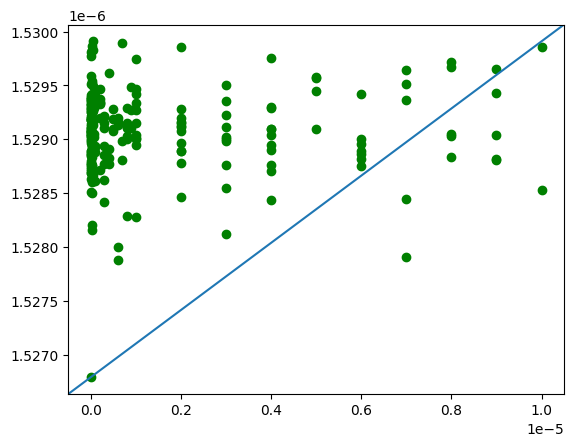

In [63]:
# re-run with best param {'activation': 'relu', 'batch_size': 128, 'epochs': 20, 'optimizer': 'SGD'}

model = create_model(optimizer=params_dict['optimizer'], activation=params_dict['activation'])
model.fit(X_train, y_train, validation_split=0.2, epochs=params_dict['epochs'], batch_size=params_dict['batch_size'])
                     
y_pred = model.predict(X_test)
scores = regression_metrics(y_test, y_pred)

In [ ]:
# def nn_cl_bo(neurons, activation, optimizer, learning_rate,  batch_size, epochs ):
#         optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
#         optimizerD = {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
#                     'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
#                     'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
#                     'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
#         activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
#                     'elu', 'exponential', 'LeakyReLU','relu']
#         neurons = round(neurons)
#         activation = activationL[round(activation)]
#         batch_size = round(batch_size)
#         epochs = round(epochs)

#         def nn_cl_fun():
#             opt = Adam(lr = learning_rate)
#             # nn = Sequential()

#             NN_model = Sequential()
#             NN_model.add(Dropout(0.2, input_dim = X_train.shape[1]))
#             NN_model.add(Dense(neurons, kernel_initializer='normal', activation=activation))
#             NN_model.add(Dense(neurons, kernel_initializer='normal', activation=activation))
#             NN_model.add(Dense(neurons, kernel_initializer='normal', activation=activation))
#             NN_model.add(Dense(neurons, kernel_initializer='normal', activation=activation))
#             NN_model.add(Dense(512, kernel_initializer='normal', activation=activation))
#             NN_model.add(Dense(512, kernel_initializer='normal', activation=activation))
#             NN_model.add(Dense(neurons, kernel_initializer='normal', activation=activation))
#             NN_model.add(Dense(neurons, kernel_initializer='normal', activation=activation))
#             NN_model.add(Dense(neurons, kernel_initializer='normal', activation=activation))
#             NN_model.add(Dense(neurons, kernel_initializer='normal', activation=activation))
#             NN_model.add(Dropout(0.1))
#             NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

#             # nn.add(Dense(neurons, input_dim=10, activation=activation))
#             # nn.add(Dense(neurons, activation=activation))
#             # nn.add(Dense(1, activation='sigmoid'))

#             NN_model.compile(loss='mean_squared_error', optimizer=Adam(0.00001), metrics=['mean_squared_error']) 
#             return NN_model
        
#         # es = EarlyStopping(monitor='mean_squared_error', mode='auto', verbose=0, patience=20)
#         # nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size, verbose=0)

#         NN_model = KerasRegressor(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size, verbose=0) 

#         kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
#         score = cross_val_score(NN_model, X_train, y_train, cv=kfold)
#         return score
    
#     # Set paramaters
#     params_nn ={
#         'neurons': (10, 100),
#         'activation':(0, 9),
#         'optimizer':(0,7),
#         'learning_rate':(0.01, 1),
#         'batch_size':(200, 1000),
#         'epochs':(20, 100)
#     }

#     # Run Bayesian Optimization
#     nn_bo = BayesianOptimization(nn_cl_bo, params_nn, random_state=111)
#     print('Tonni -----------------')
#     print(nn_bo.maximize(init_points=25, n_iter=4))
#     nn_bo.fit(X_train, y_train, validation_data=(X_train, y_train), verbose=1)
#     y_pred = nn_bo.predict(X_test)
    
#     return y_pred